In [81]:
# We import some helpful stuff
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

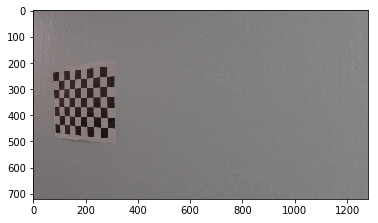

In [92]:
# We read in and display a calibration image
img = cv2.imread('camera_cal/calibration11.jpg')
plt.imshow(img)

In [24]:
# We create an array to hold the 2D image points of our calibration image
# and one to hold the 3D object points of the real world object (that is, the chessboard)
imgpoints = []
objpoints = []

In [25]:
# We ask np.zeros for a 6x9 matrix that has 3 points at every point (for x, y, & z)
# Yet z is = 0 at every point of the real world object
# Thus, we prepare object points thusly: (0,0,0), (1,0,0), (2,0,0)... (8,5,0)
objp = np.zeros((6*9, 3), np.float32)
# We then use np.mgrid to generate coordinates
# for the first two columns of objp (that is, x and y)
# for our grid of size 9, 6 and then shape them into
# a matrix of two columns
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [93]:
# To procure the image points, we use cv2.findChessboardCorners()
# on our 9 x 6 chessboard image (None refers to any flags)
# after moving the image to the grayscale color space
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

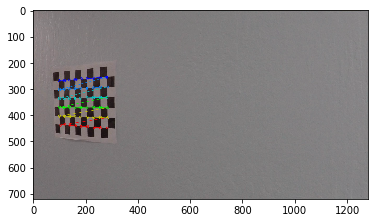

In [85]:
# If corners are found...
if ret == True:
    # append them to the image point array
    imgpoints.append(corners)
    # and append objp (created above) to the object point array
    objpoints.append(objp)
    # (Note: because objp is the ideal reference,
    # it will be compared to all of our calibration images)
    
    # Then draw the corners on our original, non-grayscale img
    # and display the image
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    plt.imshow(img)

In [102]:
# So, there's an interesting-ish thing going on...
#
# It seems drawChessboardCorners() is very sensitive
# to the size of matrix one is looking for.
# If the user doesn't specify precisely the matrix
# size that the function is able to locate in gray, it returns None for corners
# (No wonder checking if ret == True is the logic token of choice here)
#
# For example, with calibration6.jpg, it only works if I specify a (9,6) matrix,
# whereas for calibration5.jpg, the system demands a matrix of size (7,6) to work.
#
# I guess I could just quickly try all options in the 9x6 range...
# But I'd really rather just hardcode a working solution.
#
# There's a further issue: which is that the calibration images
# that Udacity has provided me with can qualitatively bedivided into two groups: 
# calibration1 - calibration5 are very different from calibration6 - calibration20
# not only aesthetically / visually, but also in regards to proximity to the chessboard;
# the latter group doesn't crop any of the edges in the way the former group does.
#
# And since I've just decided I'm lazy enough to want a hardcoded option
# I may be effectively cutting myself off from 1/4th of the data.
# This concerns me, as Cezanne said we wanted a minimum of 20 calibration images, ideally...
#
# Update: while checking the OpenCV docs for calibrateCamera(), I came across this statement: 
# "For better results, we need atleast 10 test patterns." 
# So, it seems we're good with just 14 images (6 - 20)
#

In [106]:
# So, we read in all the calibration images via the glob API, which we import
import glob

images = glob.glob('camera_cal/calibration*.jpg')
# Note: we are only able to use the wildcard * above because we have already
# removed calibration1.jpg - calibration5.jpg from the camera_cal folder

In [107]:
# This time around, let's make our chessboard settings into variables
board_x = 9
board_y = 6

In [108]:
# And let's redo the creation of imgpoints, objpoints, and objp
# just to be sure our results work with the new settings variables...
imgpoints = []
objpoints = []
objp = np.zeros((board_y*board_x, 3), np.float32)
objp[:,:2] = np.mgrid[0:board_x,0:board_y].T.reshape(-1,2)

In [128]:
# Then we iterate through the images, and apply the process developed above
for fname in images:
    # Read in image
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If corners are found...
    if ret == True:
        # append them to the image point array
        imgpoints.append(corners)
        # and append objp (created above) to the object point array
        objpoints.append(objp)
        # (Note: because objp is the ideal reference,
        # it will be compared to all of our calibration images)    

In [136]:
# With all our calibration image points and identical object points
# we are ready to feed them into cv2.calibrateCamera()
# Note: mtx is our (3D > 2D) Camera matrix, and dist our distortion coefficients
# both of which we need to transform 3D object points to 2D image points.
# rvecs and tvecs are the rotation and translation vectors that describe the camera's
# location in the world, which calibrateCamera also returns.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)


In [144]:
# We now go about applying cv2.undistort() with our long-sought mtx and dist.
# We start by applying it to one of our calibration images, which we first load and display:

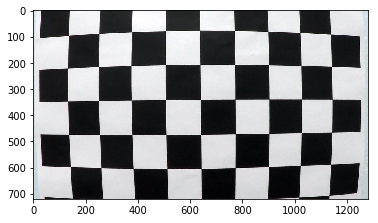

In [171]:
img = cv2.imread('camera_cal_unused/calibration1.jpg')
plt.imshow(img)

In [172]:
# And now, the same image undistorted:

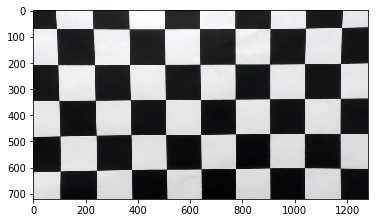

In [173]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [149]:
# Looks pretty good to my eye!
# Let's apply it to the actual test_image.png provided,
# loaded and displayed here:

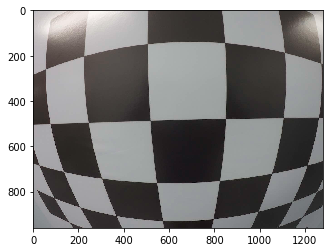

In [174]:
img = cv2.imread('camera_cal/test_image.png')
plt.imshow(img)

In [175]:
# And now with our Camera matrix and distortion co-efficients 
# applied via undistort():

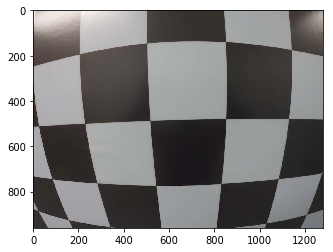

In [176]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [178]:
# One's first reaction at seeing this undistorted version of 
# test_image.png is naturally disappointment, as it is much less of 
# a dramatic and obvious correction as compared to the first 
# test image above.
#
# "Does my pipeline not actually work?" I wondered.
#
# But then I realized, "It may have worked, it's just that 
# there's even more distortion beyond what our numbers can 
# correct for, due to the way the chessboard was photographed 
# (viz. with even greater proximity.)"
#
# Which of course made me think about the mysterious 
# fifth distortion co-efficient k_3 ! 
# Could that be what's needed here, to really 
# straighten out this situation?!  : )
#
# Or, wait... maybe k_3 is already in the mix here,
# and it's just back to my original point: there are effects of 
# this camera / this shoot that are essentially overwhelming
# the undist() algorithm (fed with our numbers), even though
# it *is* actually working, and as expected...
#
# In any case, I have no desire to chase this down right now.
# My pipeline is obviously working on my given test set,
# so I'm moving on, happily... ; )